In [1]:
import pandas as pd
import numpy as np
import pyreadr
from striprtf.striprtf import rtf_to_text
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix
from sklearn.metrics import roc_auc_score
import xgboost as xgb
from plotnine import ggplot, aes, geom_point, geom_line
import matplotlib.pyplot as plt

# Data processing

In [2]:
data = pyreadr.read_r('song_data.rds') 
data = data[None]
data = data[data['tag'].isin(["pop","rock","hiphop"])]

In [3]:
def norm_minmax(x):
    return (x - min(x)) / (max(x) - min(x))

In [4]:
ml_data = pd.read_csv("GTZAN_features_30_sec.csv")

with open("GTZAN_test_filtered.rtf") as file:
    test_filtered = rtf_to_text(file.read())
with open("GTZAN_train_filtered.rtf") as file:
    train_filtered = rtf_to_text(file.read())
with open("GTZAN_valid_filtered.rtf") as file:
    valid_filtered = rtf_to_text(file.read())

test_filtered = test_filtered.replace('.wav', '').split('\n')
test_filtered = [name.split('/')[-1] for name in test_filtered]
train_filtered = train_filtered.replace('.wav', '').split('\n')
train_filtered = [name.split('/')[-1] for name in train_filtered]
valid_filtered = valid_filtered.replace('.wav', '').split('\n')
valid_filtered = [name.split('/')[-1] for name in valid_filtered]

filtered = train_filtered[:-1] + valid_filtered[:-1] + test_filtered[:-1]
filtered = [filename + '.wav' for filename in filtered]

ml_data = ml_data[ml_data['filename'].isin(filtered)]

In [5]:
# Filter and preprocess ml_data
ml_data = ml_data[ml_data['label'].isin(["pop", "rock", "hiphop"])]
ml_data = ml_data.iloc[:, [0, 2, 4, 6, 8, 10, 12, 19, 21, 23, 25, 27, 59]]
ml_data.iloc[:, 1:12] = ml_data.iloc[:, 1:12].apply(norm_minmax)

ml_data = ml_data.rename(columns={"label": "tag"})
ml_data = ml_data.rename(columns=lambda x: x.replace("_mean", "_norm", 1) if "_mean" in x else x)
ml_data = ml_data.rename(columns={"rms_norm": "rmse_norm"})

# Set seed and split data
seed = 210016
ml_train = ml_data.groupby('tag', group_keys=True).apply(lambda x: x.sample(frac=0.8, random_state=seed)).reset_index(drop=True)
ml_test = pd.concat([ml_data, ml_train]).drop_duplicates(keep=False)

ml_train = ml_train.iloc[:, [12] + list(range(1, 12))]
ml_test = ml_test.iloc[:, [12] + list(range(1, 12))]

In [6]:
print(ml_train)

        tag  chroma_stft_norm  rmse_norm  spectral_centroid_norm  \
0    hiphop          0.415608   0.324663                0.523182   
1    hiphop          0.659209   0.355072                0.491339   
2    hiphop          0.556153   0.203278                0.187693   
3    hiphop          1.000000   0.195540                0.424375   
4    hiphop          0.761360   0.500669                0.615079   
..      ...               ...        ...                     ...   
214    rock          0.378613   0.164894                0.124747   
215    rock          0.390238   0.396507                0.114392   
216    rock          0.610983   0.225947                0.530034   
217    rock          0.481192   0.319038                0.330753   
218    rock          0.476515   0.176055                0.294554   

     spectral_bandwidth_norm  rolloff_norm  zero_crossing_rate_norm  \
0                   0.583149      0.548507                 0.391563   
1                   0.396094      0.48698

# Training

## Naive Bayes

In [7]:
nb_model = GaussianNB()
nb_model.fit(ml_train.iloc[:, 1:], ml_train['tag'])
p_train = nb_model.predict(ml_train.iloc[:, 1:])
p_test = nb_model.predict(ml_test.iloc[:, 1:])
p_test_prob = nb_model.predict_proba(ml_test.iloc[:, 1:])
accuracy_train = (p_train == ml_train['tag']).mean()
accuracy_test = (p_test == ml_test['tag']).mean()
auc_score = roc_auc_score(pd.get_dummies(ml_test['tag']), p_test_prob, multi_class='ovr')

print("Naive Bayes Accuracy (Train):", accuracy_train)
print("Naive Bayes Accuracy (Test):", accuracy_test)
print("Naive Bayes AUC:", auc_score)

Naive Bayes Accuracy (Train): 0.684931506849315
Naive Bayes Accuracy (Test): 0.7407407407407407
Naive Bayes AUC: 0.8556050952421782


## KNN

In [8]:
df_knn_auc = pd.DataFrame()
for k in range(1, 61):
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(ml_train.iloc[:, 1:], ml_train['tag'])
    acc = knn_model.score(ml_test.iloc[:, 1:], ml_test['tag'])
    auc = roc_auc_score(pd.get_dummies(ml_test['tag']), knn_model.predict_proba(ml_test.iloc[:, 1:]), multi_class='ovr')
    df_knn_auc = pd.concat([df_knn_auc, pd.DataFrame({'k': [k], 'acc': [acc], 'auc': [auc]})])

df_knn_auc = df_knn_auc.sort_values(by=['acc', 'auc'], ascending=False)
print(df_knn_auc.head(10))

k_4 = KNeighborsClassifier(n_neighbors=4)
k_4.fit(ml_train.iloc[:, 1:], ml_train['tag'])
accuracy_k4 = k_4.score(ml_test.iloc[:, 1:], ml_test['tag'])
auc_k4 = roc_auc_score(pd.get_dummies(ml_test['tag']), k_4.predict_proba(ml_test.iloc[:, 1:]), multi_class='ovr')

print("KNN (k=4) Accuracy:", accuracy_k4)
print("KNN (k=4) AUC:", auc_k4)

    k       acc       auc
0  31  0.777778  0.884562
0  32  0.777778  0.884544
0  28  0.759259  0.885783
0  26  0.759259  0.885437
0  27  0.759259  0.885015
0  25  0.759259  0.880853
0  33  0.759259  0.880735
0  30  0.740741  0.888348
0  29  0.740741  0.888096
0  21  0.740741  0.884198
KNN (k=4) Accuracy: 0.6481481481481481
KNN (k=4) AUC: 0.8516327282366154


## Random Forest

In [9]:
df_rf_auc = pd.DataFrame()
for n in range(1, 61):
    for max_depth in range(30, 61):
        rf_model = RandomForestClassifier(n_estimators=n, max_depth=max_depth)
        rf_model.fit(ml_train.iloc[:, 1:], ml_train['tag'])
        p_test_prob_rf = rf_model.predict_proba(ml_test.iloc[:, 1:])
        acc = rf_model.score(ml_test.iloc[:, 1:], ml_test['tag'])
        auc = roc_auc_score(pd.get_dummies(ml_test['tag']), p_test_prob_rf, multi_class='ovr')
        df_rf_auc = pd.concat([df_rf_auc, pd.DataFrame({'n': [n], 'max_depth': [max_depth], 'acc': [acc], 'auc': [auc]})])

df_rf_auc = df_rf_auc.sort_values(by=['acc', 'auc'], ascending=False)
print(df_rf_auc.head(10))

rf_20_39 = RandomForestClassifier(n_estimators=20, max_depth=39)
rf_20_39.fit(ml_train.iloc[:, 1:], ml_train['tag'])
accuracy_rf_20_39 = rf_20_39.score(ml_test.iloc[:, 1:], ml_test['tag'])
p_test_prob_rf_20_39 = rf_20_39.predict_proba(ml_test.iloc[:, 1:])
auc_rf_20_39 = roc_auc_score(pd.get_dummies(ml_test['tag']), p_test_prob_rf_20_39, multi_class='ovr')

print("Random Forest (n=20, max_depth=39) Accuracy:", accuracy_rf_20_39)
print("Random Forest (n=20, max_depth=39) AUC:", auc_rf_20_39)

    n  max_depth       acc       auc
0  12         35  0.833333  0.926787
0  15         45  0.833333  0.926021
0  57         42  0.833333  0.925833
0  36         44  0.833333  0.925745
0  44         40  0.833333  0.925122
0  33         38  0.833333  0.923745
0  60         52  0.833333  0.921868
0  21         48  0.814815  0.931543
0   9         43  0.814815  0.928898
0  51         56  0.814815  0.924613
Random Forest (n=20, max_depth=39) Accuracy: 0.7222222222222222
Random Forest (n=20, max_depth=39) AUC: 0.8908142115529456


## XGBoost

In [10]:
# Convert genre labels to numeric values for XGBoost
ml_train_num = ml_train.replace({'tag': {'pop': 0, 'hiphop': 1, 'rock': 2}})
ml_test_num = ml_test.replace({'tag': {'pop': 0, 'hiphop': 1, 'rock': 2}})

# Create DMatrix for XGBoost training and testing
train_matrix = xgb.DMatrix(data=ml_train_num.iloc[:, 1:], label=ml_train_num['tag'])
test_matrix = xgb.DMatrix(data=ml_test_num.iloc[:, 1:], label=ml_test_num['tag'])

# Hyperparameter tuning for XGBoost
best_param = {}
best_seednumber = 1234
best_logloss = np.inf
best_logloss_index = 0

for n in range(100):
    print(n)
    param = {
        'objective': 'multi:softprob',
        'eval_metric': 'mlogloss',
        'num_class': 3,
        'max_depth': np.random.choice([2, 3, 4, 5]),
        'eta': np.random.uniform(0.01, 0.1),
        # Additional hyperparameters can be added here
    }

    cv_nround = 500
    cv_nfold = 5
    seed_number = np.random.randint(10000)
    np.random.seed(seed_number)
    mdcv = xgb.cv(params=param, dtrain=train_matrix, nfold=cv_nfold, num_boost_round=cv_nround,
                  early_stopping_rounds=8, maximize=False)

    min_logloss = min(mdcv['test-mlogloss-mean'])
    min_logloss_index = np.argmin(mdcv['test-mlogloss-mean'])

    if min_logloss < best_logloss:
        best_logloss = min_logloss
        best_logloss_index = min_logloss_index
        best_seednumber = seed_number
        best_param = param

# Train the final XGBoost model
nround = best_logloss_index
np.random.seed(best_seednumber)
bst_model = xgb.train(params=best_param, dtrain=train_matrix, num_boost_round=nround)

# Predict on the hold-out test set
test_pred = bst_model.predict(test_matrix)
# test_prediction = pd.DataFrame(test_pred, columns=['pop', 'hiphop', 'rock']).idxmax(axis=1)
test_prediction = pd.DataFrame(test_pred, columns=['pop', 'hiphop', 'rock']).apply(lambda x: np.argmax(x), axis=1)

# Confusion matrix of the test set
conf_matrix = confusion_matrix(ml_test_num['tag'], test_prediction)

# Calculate and print the AUC for the test set
test_auc = roc_auc_score(ml_test_num['tag'], test_pred, multi_class='ovr')
print(f"AUC for the test set: {test_auc}")

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
AUC for the test set: 0.9308601010957392


# Prediction

In [11]:
# data_predict = data[data['release_year'].isin([2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019])]
data_predict = data[data['release_year'].isin(['2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019'])]
data_predict.loc[:,'release_year'] = pd.to_datetime(data_predict.loc[:,'release_date']).dt.year
data_predict.loc[:,'tag_bin'] = np.where(data_predict.loc[:,'tag'] == 'hiphop', 'hiphop', 'nonhiphop')
data_predict.loc[:,'treatment_date'] = np.where(data_predict.loc[:,'release_date'] < pd.to_datetime('2017-06-24'), 0, 1)
data_predict.loc[:,'treatment_year'] = np.where(data_predict.loc[:,'release_year'] < 2017, 0, 1)
x_data_predict = data_predict.iloc[:, 6:17]

/tmp/ipykernel_5290/3366969337.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_5290/3366969337.py:3: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
/tmp/ipykernel_5290/3366969337.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_5290/3366969337.py:5: FutureWarn

## Naive Bayes

In [12]:
data_predict.loc[:,'gnb_pred'] = nb_model.predict(x_data_predict)
data_predict.loc[:,'gnb_pred_acc'] = data_predict['gnb_pred'] == data_predict['tag']
data_predict.loc[:,'gnb_pred_bin'] = np.where(data_predict['gnb_pred'] == 'hiphop', 'hiphop', 'nonhiphop')
data_predict.loc[:,'gnb_pred_bin_acc'] = data_predict['tag_bin'] == data_predict['gnb_pred_bin']

/tmp/ipykernel_5290/525581518.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_5290/525581518.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_5290/525581518.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_5290/52558151

## K-Nearest Neighbors

In [13]:
data_predict['knn_pred'] = knn_model.predict(x_data_predict)
data_predict['knn_pred_acc'] = (data_predict['knn_pred'] == data_predict['tag']).astype(int)
data_predict['knn_pred_bin'] = data_predict['knn_pred'].map({'hiphop': 'hiphop', 'pop': 'nonhiphop'})
data_predict['knn_pred_bin_acc'] = (data_predict['tag_bin'] == data_predict['knn_pred_bin']).astype(int)

/tmp/ipykernel_5290/1251774408.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_5290/1251774408.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_5290/1251774408.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_5290/12517

## Random Forest

In [14]:
data_predict['rf_pred'] = rf_model.predict(x_data_predict)
data_predict['rf_pred_acc'] = (data_predict['rf_pred'] == data_predict['tag']).astype(int)
data_predict['rf_pred_bin'] = data_predict['rf_pred'].map({'hiphop': 'hiphop', 'pop': 'nonhiphop'})
data_predict['rf_pred_bin_acc'] = (data_predict['tag_bin'] == data_predict['rf_pred_bin']).astype(int)

/tmp/ipykernel_5290/2113506275.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_5290/2113506275.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_5290/2113506275.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_5290/21135

## XGBoost

In [15]:
data_predict_xgb = bst_model.predict(xgb.DMatrix(x_data_predict))
data_predict['xgb_pred'] = pd.DataFrame(data_predict_xgb).apply(lambda x: x.idxmax(), axis=1)
data_predict['xgb_pred_acc'] = (data_predict['xgb_pred'] == data_predict['tag']).astype(int)
data_predict['xgb_pred_bin'] = data_predict['xgb_pred'].map({'hiphop': 'hiphop', 'pop': 'nonhiphop'})
data_predict['xgb_pred_bin_acc'] = (data_predict['tag_bin'] == data_predict['xgb_pred_bin']).astype(int)

/tmp/ipykernel_5290/2954023184.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_5290/2954023184.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_5290/2954023184.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_5290/29540

In [ ]:
print(data_predict.columns)
data_predict.to_pickle('pickles/data_predict_GTZAN.pkl')

# Metrics

## Naive Bayes

,release_year,treatment_year,gnb_pred_acc,gnb_pred_bin_acc,gnb_recall,gnb_precision
0,2009,0,0.162981,0.811630,0.500000,0.117391
1,2010,0,0.187803,0.805267,0.437956,0.227273
2,2011,0,0.275306,0.807866,0.415929,0.168459
3,2012,0,0.247118,0.761905,0.391144,0.254808
4,2013,0,0.227344,0.758471,0.375796,0.220561
5,2014,0,0.284012,0.727457,0.388060,0.302326
6,2015,0,0.315108,0.767815,0.412854,0.340215
7,2016,0,0.257576,0.779336,0.388693,0.279661
8,2017,1,0.263714,0.773520,0.424524,0.467194
9,2018,1,0.221647,0.774880,0.414466,0.535537


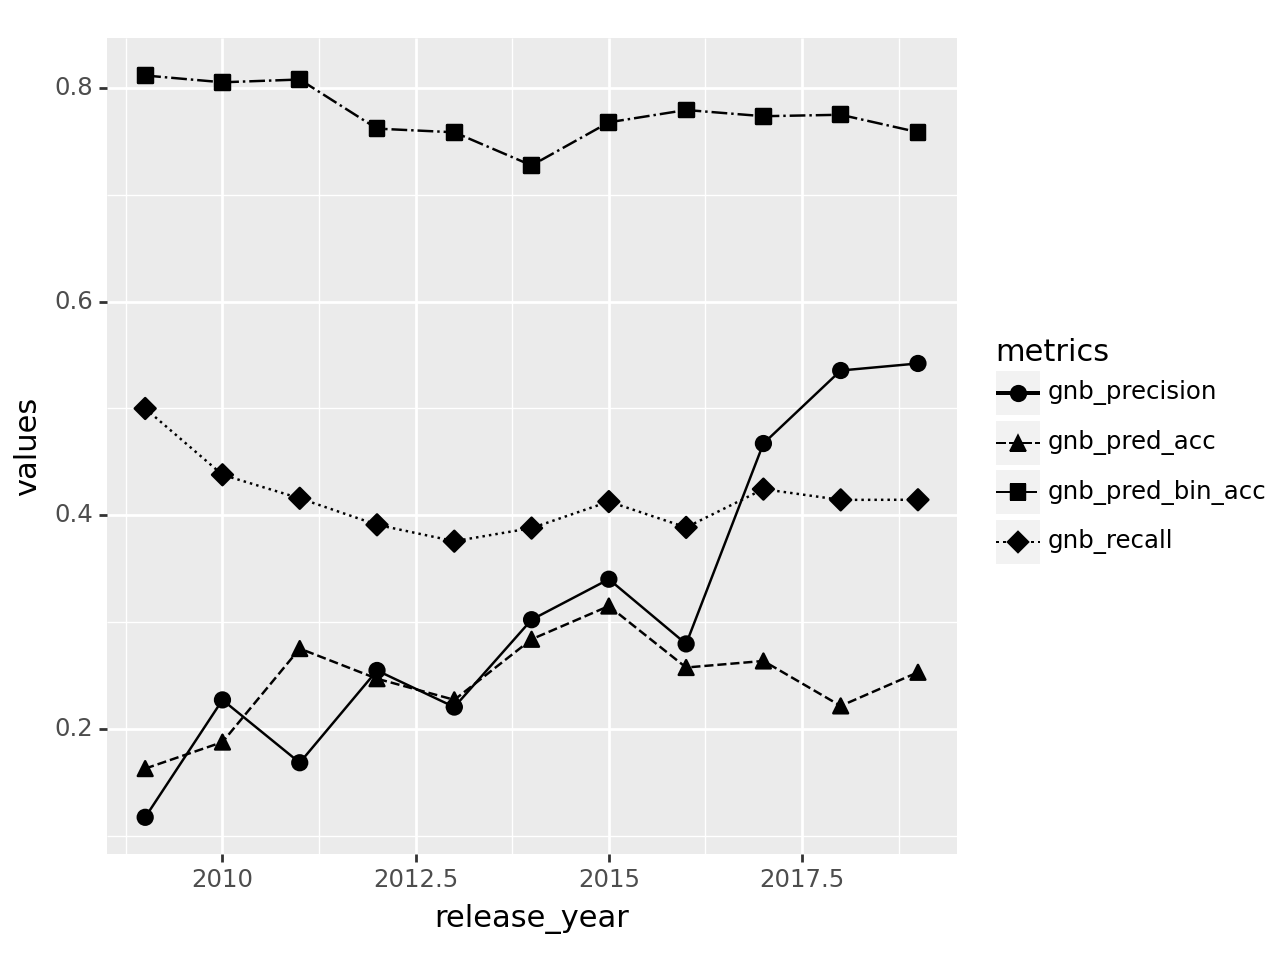

In [21]:
gnb_mean_acc_tbyyear = data_predict.groupby(['release_year', 'treatment_year'])['gnb_pred_acc'].mean().reset_index()
gnb_mean_bin_acc_tbyyear = data_predict.groupby(['release_year', 'treatment_year'])['gnb_pred_bin_acc'].mean().reset_index()
gnb_recall_tbyyear = data_predict[data_predict['tag'] == 'hiphop'].groupby(['release_year', 'treatment_year'])['gnb_pred_acc'].mean().reset_index().rename(columns={'gnb_pred_acc':'gnb_recall'})
gnb_precision_tbyyear = data_predict[data_predict['gnb_pred'] == 'hiphop'].groupby(['release_year', 'treatment_year'])['gnb_pred_acc'].mean().reset_index().rename(columns={'gnb_pred_acc':'gnb_precision'})
gnb_metrics = pd.concat([gnb_mean_acc_tbyyear, gnb_mean_bin_acc_tbyyear['gnb_pred_bin_acc'], gnb_recall_tbyyear['gnb_recall'], gnb_precision_tbyyear['gnb_precision']], axis=1)
display(gnb_metrics)
gnb_metrics = gnb_metrics.melt(id_vars=['release_year', 'treatment_year'], var_name='metrics', value_name='values')
gnb_metrics_plot = ggplot(gnb_metrics, aes(x='release_year', y='values')) + geom_point(aes(shape='metrics'), size=2.5) + geom_line(aes(linetype='metrics'))
print(gnb_metrics_plot)

gnb_metrics.to_pickle('pickles/gnb_metrics_gtzan.pkl')

## K-Nearest Neighbors

,release_year,treatment_year,knn_pred_acc,knn_pred_bin_acc,knn_recall,knn_precision
0,2009,0,0.160524,0.090090,0.611111,0.085492
1,2010,0,0.200970,0.125433,0.693431,0.192698
2,2011,0,0.264346,0.121212,0.628319,0.142285
3,2012,0,0.220050,0.115288,0.520295,0.186016
4,2013,0,0.225768,0.128054,0.570064,0.190223
5,2014,0,0.284461,0.147965,0.541045,0.271536
6,2015,0,0.289047,0.132130,0.565359,0.266427
7,2016,0,0.237427,0.113475,0.492344,0.214469
8,2017,1,0.272933,0.161952,0.588584,0.395679
9,2018,1,0.248575,0.175719,0.589659,0.450609


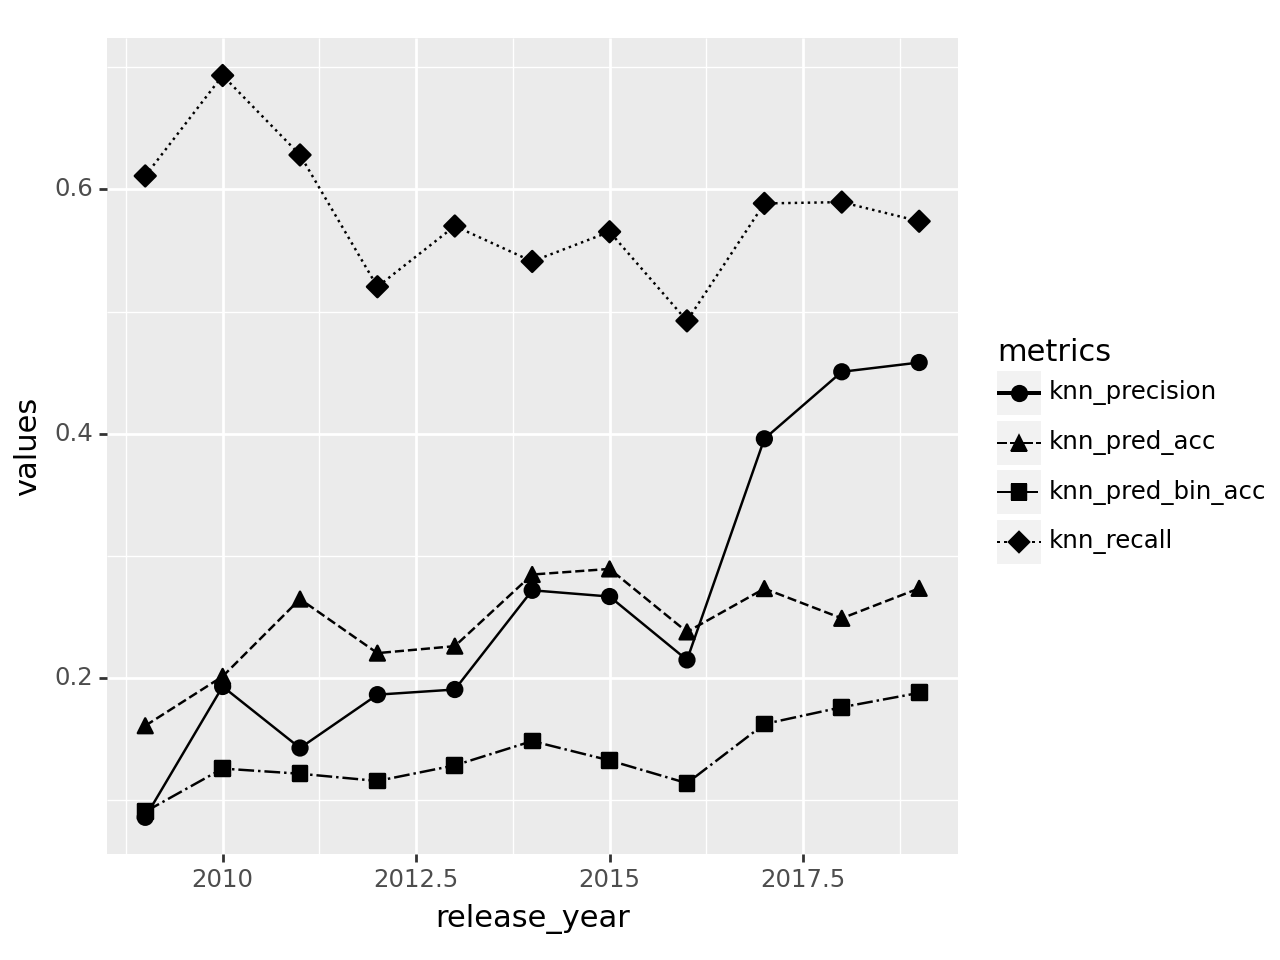

In [22]:
knn_mean_acc_tbyyear = data_predict.groupby(['release_year', 'treatment_year'])['knn_pred_acc'].mean().reset_index()
knn_mean_bin_acc_tbyyear = data_predict.groupby(['release_year', 'treatment_year'])['knn_pred_bin_acc'].mean().reset_index()
knn_recall_tbyyear = data_predict[data_predict['tag'] == 'hiphop'].groupby(['release_year', 'treatment_year'])['knn_pred_acc'].mean().reset_index().rename(columns={'knn_pred_acc':'knn_recall'})
knn_precision_tbyyear = data_predict[data_predict['knn_pred'] == 'hiphop'].groupby(['release_year', 'treatment_year'])['knn_pred_acc'].mean().reset_index().rename(columns={'knn_pred_acc':'knn_precision'})
knn_metrics = pd.concat([knn_mean_acc_tbyyear, knn_mean_bin_acc_tbyyear['knn_pred_bin_acc'], knn_recall_tbyyear['knn_recall'], knn_precision_tbyyear['knn_precision']], axis=1)
display(knn_metrics)
knn_metrics = knn_metrics.melt(id_vars=['release_year', 'treatment_year'], var_name='metrics', value_name='values')
knn_metrics_plot = ggplot(knn_metrics, aes(x='release_year', y='values')) + geom_point(aes(shape='metrics'), size=2.5) + geom_line(aes(linetype='metrics'))
print(knn_metrics_plot)

knn_metrics.to_pickle('pickles/knn_metrics_gtzan.pkl')

## Random Forest

,release_year,treatment_year,rf_pred_acc,rf_pred_bin_acc,rf_recall,rf_precision
0,2009,0,0.289926,0.226044,0.481481,0.098485
1,2010,0,0.333333,0.259875,0.525547,0.193029
2,2011,0,0.402966,0.257253,0.389381,0.119891
3,2012,0,0.366416,0.260150,0.357934,0.175090
4,2013,0,0.348700,0.265957,0.372611,0.181677
5,2014,0,0.376209,0.247583,0.338308,0.244824
6,2015,0,0.372699,0.231092,0.369281,0.250554
7,2016,0,0.340103,0.231947,0.315665,0.204893
8,2017,1,0.334297,0.232083,0.388161,0.380282
9,2018,1,0.316976,0.243334,0.374587,0.429247


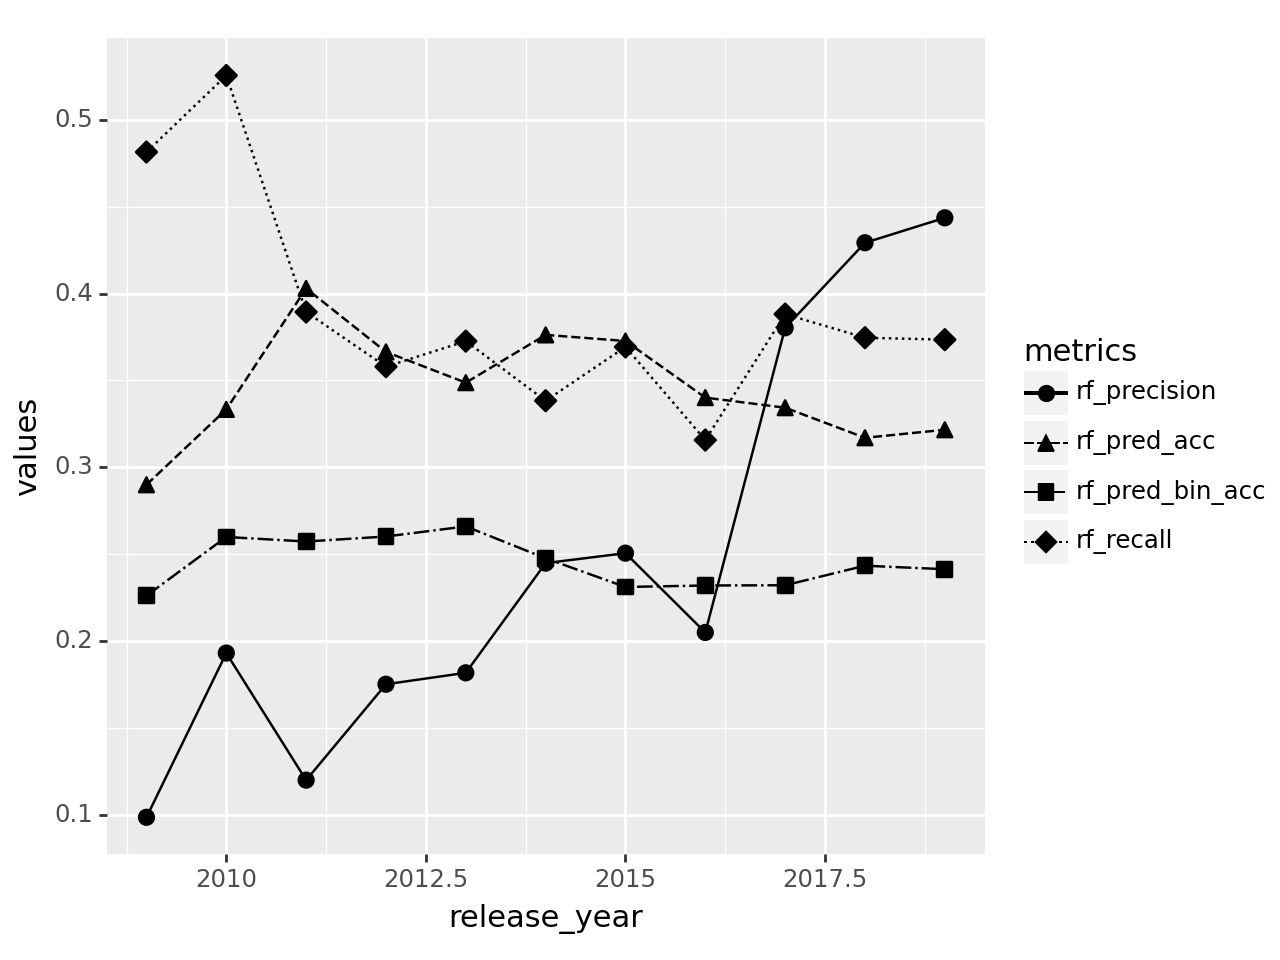

In [23]:
rf_mean_acc_tbyyear = data_predict.groupby(['release_year', 'treatment_year'])['rf_pred_acc'].mean().reset_index()
rf_mean_bin_acc_tbyyear = data_predict.groupby(['release_year', 'treatment_year'])['rf_pred_bin_acc'].mean().reset_index()
rf_recall_tbyyear = data_predict[data_predict['tag'] == 'hiphop'].groupby(['release_year', 'treatment_year'])['rf_pred_acc'].mean().reset_index().rename(columns={'rf_pred_acc':'rf_recall'})
rf_precision_tbyyear = data_predict[data_predict['rf_pred'] == 'hiphop'].groupby(['release_year', 'treatment_year'])['rf_pred_acc'].mean().reset_index().rename(columns={'rf_pred_acc':'rf_precision'})
rf_metrics = pd.concat([rf_mean_acc_tbyyear, rf_mean_bin_acc_tbyyear['rf_pred_bin_acc'], rf_recall_tbyyear['rf_recall'], rf_precision_tbyyear['rf_precision']], axis=1)
display(rf_metrics)
rf_metrics = rf_metrics.melt(id_vars=['release_year', 'treatment_year'], var_name='metrics', value_name='values')
rf_metrics_plot = ggplot(rf_metrics, aes(x='release_year', y='values')) + geom_point(aes(shape='metrics'), size=2.5) + geom_line(aes(linetype='metrics'))
print(rf_metrics_plot)

rf_metrics.to_pickle('pickles/rf_metrics_gtzan.pkl')

## XGBoost

,release_year,treatment_year,xgb_pred_acc,xgb_pred_bin_acc,xgb_recall,xgb_precision
0,2009,0,0.0,0.0,0.0,NaN
1,2010,0,0.0,0.0,0.0,NaN
2,2011,0,0.0,0.0,0.0,NaN
3,2012,0,0.0,0.0,0.0,NaN
4,2013,0,0.0,0.0,0.0,NaN
5,2014,0,0.0,0.0,0.0,NaN
6,2015,0,0.0,0.0,0.0,NaN
7,2016,0,0.0,0.0,0.0,NaN
8,2017,1,0.0,0.0,0.0,NaN
9,2018,1,0.0,0.0,0.0,NaN


/home/priscilla/Programmes/anaconda3/lib/python3.10/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 11 rows containing missing values.
/home/priscilla/Programmes/anaconda3/lib/python3.10/site-packages/plotnine/geoms/geom_path.py:98: PlotnineWarning: geom_path: Removed 11 rows containing missing values.


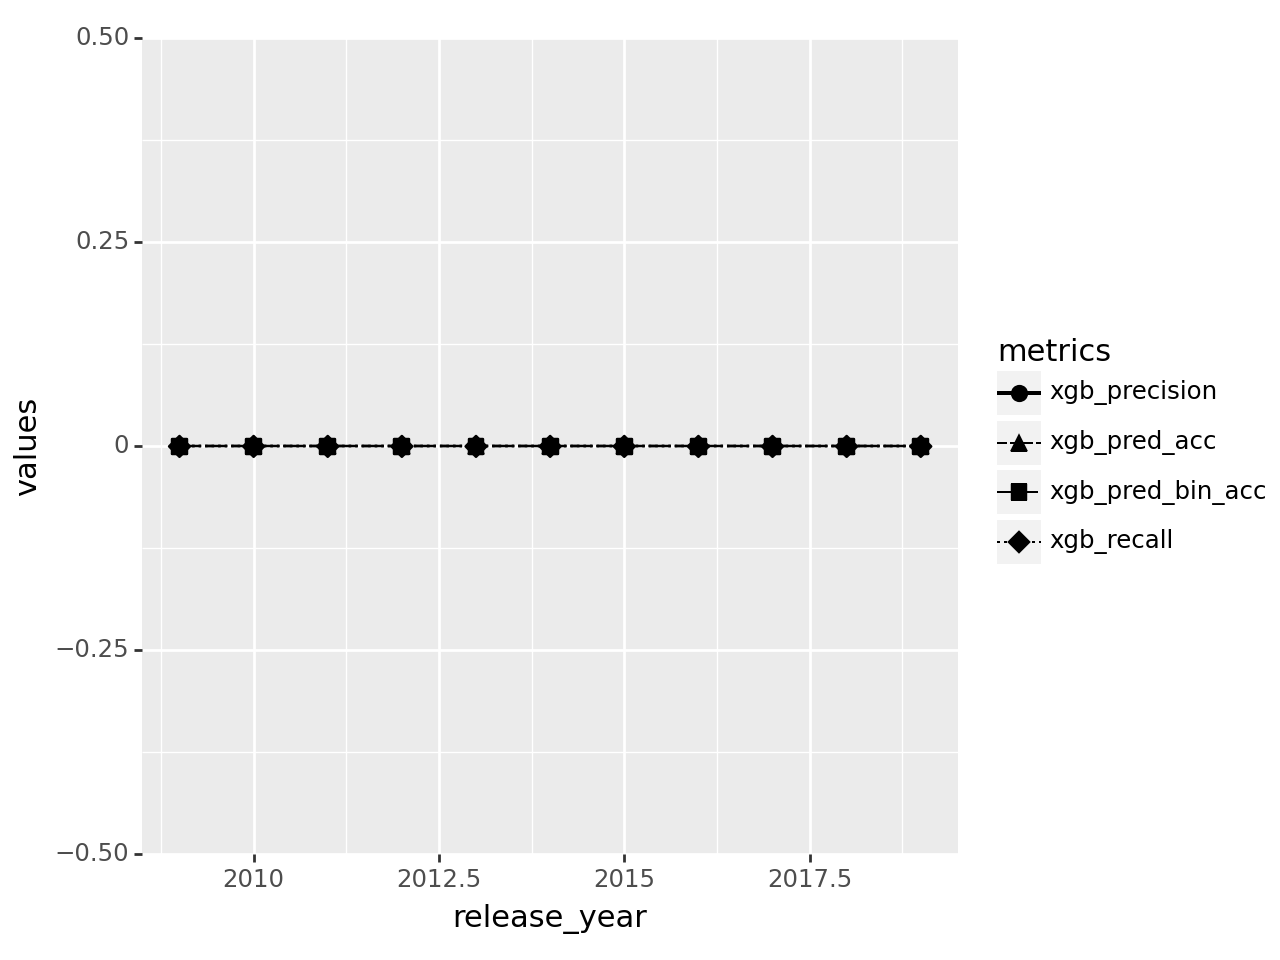

In [24]:
# xgb_mean_acc_tbyyear = data_predict.groupby(['release_year', 'treatment_year'])['xgb_pred_acc'].mean().reset_index()
# xgb_mean_bin_acc_tbyyear = data_predict.groupby(['release_year', 'treatment_year'])['xgb_pred_bin_acc'].mean().reset_index()
# xgb_recall_tbyyear = data_predict[data_predict['tag'] == 'hiphop'].groupby(['release_year', 'treatment_year'])['xgb_pred_acc'].mean().reset_index().rename(columns={'xgb_pred_acc':'xgb_recall'})
# xgb_precision_tbyyear = data_predict[data_predict['xgb_pred'] == 'hiphop'].groupby(['release_year', 'treatment_year'])['xgb_pred_acc'].mean().reset_index().rename(columns={'xgb_pred_acc':'xgb_precision'})
# xgb_metrics = pd.concat([xgb_mean_acc_tbyyear, xgb_mean_bin_acc_tbyyear['xgb_pred_bin_acc'], xgb_recall_tbyyear['xgb_recall'], xgb_precision_tbyyear['xgb_precision']], axis=1)
# display(xgb_metrics)
# xgb_metrics = xgb_metrics.melt(id_vars=['release_year', 'treatment_year'], var_name='metrics', value_name='values')

xgb_mean_acc_tbyyear     = data_predict.copy().groupby(['release_year', 'treatment_year'])['xgb_pred_acc'].mean().reset_index()
xgb_mean_bin_acc_tbyyear = data_predict.copy().groupby(['release_year', 'treatment_year'])['xgb_pred_bin_acc'].mean().reset_index()
xgb_recall_tbyyear       = data_predict.copy()[data_predict['tag'] == 'hiphop'].groupby(['release_year', 'treatment_year'])['xgb_pred_acc'].mean().reset_index().rename(columns={'xgb_pred_acc':'xgb_recall'})
xgb_precision_tbyyear    = data_predict.copy()[data_predict['xgb_pred'] == 'hiphop'].groupby(['release_year', 'treatment_year'])['xgb_pred_acc'].mean().reset_index().rename(columns={'xgb_pred_acc':'xgb_precision'})
xgb_metrics = pd.concat([xgb_mean_acc_tbyyear, xgb_mean_bin_acc_tbyyear['xgb_pred_bin_acc'], xgb_recall_tbyyear['xgb_recall'], xgb_precision_tbyyear['xgb_precision']], axis=1)
display(xgb_metrics)
xgb_metrics = xgb_metrics.melt(id_vars=['release_year', 'treatment_year'], var_name='metrics', value_name='values')

xgb_metrics_plot = ggplot(xgb_metrics, aes(x='release_year', y='values')) + geom_point(aes(shape='metrics'), size=2.5) + geom_line(aes(linetype='metrics'))
print(xgb_metrics_plot)

xgb_metrics.to_pickle('pickles/xgb_metrics_gtzan.pkl')

## Average

,release_year,treatment_year,metrics,values
0,2009,0,classifiers_pred_acc,0.153358
1,2010,0,classifiers_pred_acc,0.180527
2,2011,0,classifiers_pred_acc,0.235654
3,2012,0,classifiers_pred_acc,0.208396
4,2013,0,classifiers_pred_acc,0.200453
5,2014,0,classifiers_pred_acc,0.236170
6,2015,0,classifiers_pred_acc,0.244214
7,2016,0,classifiers_pred_acc,0.208777
8,2017,1,classifiers_pred_acc,0.217736
9,2018,1,classifiers_pred_acc,0.196799


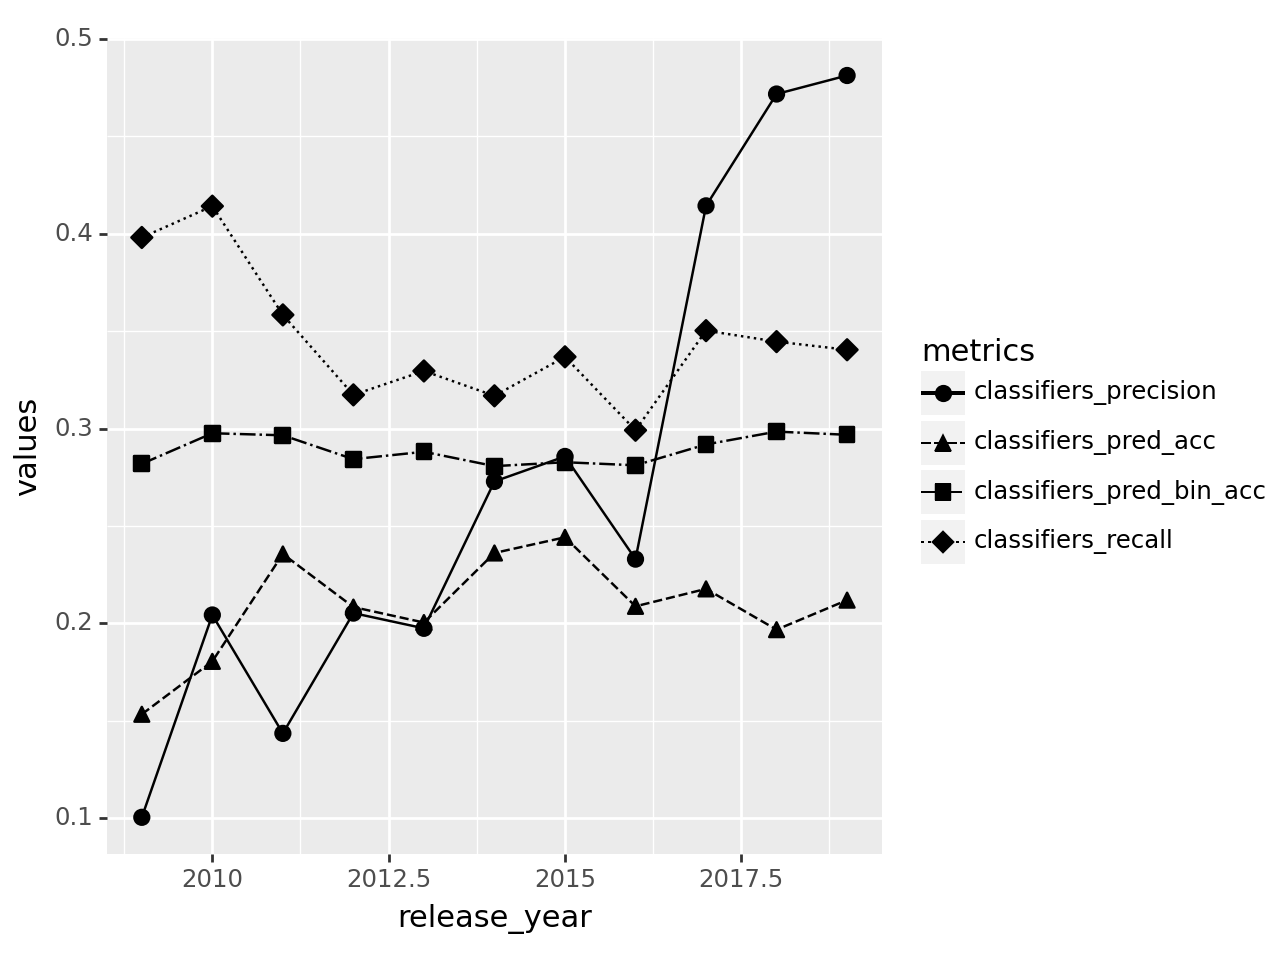

In [27]:
average = pd.concat([gnb_metrics['values'], knn_metrics['values'], rf_metrics['values'], xgb_metrics['values']], names = ['values', 'values_1', 'values_2', 'values_3'], axis=1)
average = average.mean(axis=1)
average = pd.concat([gnb_metrics['release_year'], gnb_metrics['treatment_year'], gnb_metrics['metrics'], average],axis=1)
average['metrics'] = average['metrics'].str.replace('gnb_', 'classifiers_')
average = average.rename(columns={0: "values"})
average.to_pickle('pickles/classifiers_metrics_gtzan.pkl')
display(average)

average_plot = ggplot(average, aes(x='release_year', y='values')) + geom_point(aes(shape='metrics'), size=2.5) + geom_line(aes(linetype='metrics'))
print(average_plot)